In [89]:
import os
import sys
import re
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda, Reshape, add, dot, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import get_file
import tensorflow.keras.backend as K

# Read and process data 

In [112]:
# get the data and open the compressed file using the tarfile library
# https://research.fb.com/downloads/babi/
path = get_file(
    'babi-tasks-v1-2.tar.gz',
    origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
tar = tarfile.open(path)


# relevant data in the tar file
# there's lots more data in there, check it out if you want!
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}

In [113]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.

    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+?)', sent) if x.strip()]


def flatten(l):
    for el in l:
        if not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def vectorize_stories(data, word2idx, story_maxlen, query_maxlen):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([[word2idx[w] for w in s] for s in story])
        queries.append([word2idx[w] for w in query])
        answers.append([word2idx[answer]])
    return (
        [pad_sequences(x, maxlen=story_maxlen) for x in inputs],
        pad_sequences(queries, maxlen=query_maxlen),
        np.array(answers)
    )


def stack_inputs(inputs, story_maxsents, story_maxlen):
    for i, story in enumerate(inputs):
        inputs[i] = np.concatenate(
            [
                story,
                np.zeros((story_maxsents-story.shape[0], story_maxlen), 'int')
            ]
        )
    return np.stack(inputs)

In [114]:
def get_stories(f):
    # data will return a list of triples
    # each triple contains:
    #   1. a story
    #   2. a question about the story
    #   3. the answer to the question
    data = []

    # use this list to keep track of the story so far
    stories = []
    printed = False
    for line in f:
        line = line.decode('utf-8').strip()

        # split the line number from the rest of the line
        nid, line = line.split(' ', 1)

        # see if we should begin a new story
        if int(nid) == 1:
            story = []

        # this line contains a question and answer if it has a tab
        #       question<TAB>answer
        # it also tells us which line in the story is relevant to the answer
        # Note: we actually ignore this fact, since the model will learn
        #       which lines are important
        # Note: the max line number is not the number of lines of the story
        #       since lines with questions do not contain any story
        # one story may contain MULTIPLE questions
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)

            # numbering each line is very useful
            # it's the equivalent of adding a unique token to the front
            # of each sentence
            story_so_far = [[str(i)] + s for i, s in enumerate(story) if s]
            data.append((story_so_far, q, a))
            story.append('')
        else:
            story.append(tokenize(line))
    return data

In [116]:
def get_data(challenge_type):
    challenge = challenges[challenge_type]
    # returns a list of triples of:
    # (story, question, answer)
    # story is a list of sentences
    # question is a sentence
    # answer is a word
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))
    # group all the stories together
    stories = train_stories+test_stories

    # so we can get the max length of each story, of each sentence, and of each question
    story_maxlen = max(len(s) for lines, _, _ in stories for s in lines)
    story_maxsents = max(len(lines) for lines, _, _ in stories)
    query_maxlen = max(len(q) for _, q, _ in stories)

    # Create vocabulary of corpus and find size, including a padding element.
    vocab = sorted(set(flatten(stories)))
    vocab.insert(0, '<PAD>')
    vocab_size = len(vocab)

    # Create an index mapping for the vocabulary.
    word2idx = {word: i for i, word in enumerate(vocab)}

    # convert stories from strings to lists of integers
    inputs_train, queries_train, answers_train = vectorize_stories(
        train_stories,
        word2idx,
        story_maxlen,
        query_maxlen
    )

    inputs_test, queries_test, answers_test = vectorize_stories(
        test_stories,
        word2idx,
        story_maxlen,
        query_maxlen
    )

    # convert inputs into 3-D numpy arrays
    inputs_train = stack_inputs(inputs_train, story_maxsents, story_maxlen)
    inputs_test = stack_inputs(inputs_test, story_maxsents, story_maxlen)
    print("inputs_train.shape, inputs_test.shape",
          inputs_train.shape, inputs_test.shape)

    # return model inputs for keras
    return train_stories, \
        test_stories, \
        inputs_train, \
        queries_train, \
        answers_train, \
        inputs_test, \
        queries_test, \
        answers_test, \
        story_maxsents, \
        story_maxlen, \
        query_maxlen, \
        vocab, \
        vocab_size

In [117]:
# get the single supporting fact data
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('single_supporting_fact_10k')

inputs_train.shape, inputs_test.shape (10000, 10, 8) (1000, 10, 8)


# Create the model 

In [118]:
embedding_dim = 15

# turn the story into a sequence of embedding vectors
# one for each story line
# treating each story line like a "bag of words"
input_story_ = Input(shape=(story_maxsents, story_maxlen))
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x: K.sum(x, axis=2))(embedded_story)
print("input_story_.shape, embedded_story.shape:",
      input_story_.shape, embedded_story.shape)

In [121]:
# turn the question into an embedding
# also a bag of words
input_question_ = Input(shape=(query_maxlen,))
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)
print("input_question_.shape, embedding_question.shape:",
      input_question_.shape, embedded_question.shape)

# add a "sequence length" of 1 so that it can
# be dotted with the story later
embedded_question = Reshape((1, embedding_dim))(embedded_question)
print("inp_q.shape, emb_q.shape:", input_question_.shape, embedded_question.shape)

input_question_.shape, embedding_question.shape: (None, 4) (None, 15)


In [123]:
# calculate the weights for each story line
# embedded_story.shape        = (N, num sentences, embedding_dim)
# embedded_question.shape     = (N, 1, embedding_dim)
x = dot([embedded_story, embedded_question], 2)
print(x.shape)
x = Reshape((story_maxsents,))(x)  # flatten the vector
print(x.shape)
x = Activation('softmax')(x)
print(x.shape)
story_weights = Reshape((story_maxsents, 1))(
    x)  # unflatten it again to be dotted later
print(story_weights.shape)

(None, 10, 1)
(None, 10)
(None, 10)
(None, 10, 1)


In [124]:
x = dot([story_weights, embedded_story], 1)
x = Reshape((embedding_dim,))(x)
ans = Dense(vocab_size, activation='softmax')(x)

In [125]:
# make the model
model = Model([input_story_, input_question_], ans)

# compile the model
model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=Adam(lr=0.01))

In [126]:
# train the model
r = model.fit([inputs_train, queries_train],
              answers_train,
              batch_size=32,
              epochs=30,
              validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/30
313/313 [==============================] - 0s 803us/step - loss: 0.8748 - accuracy: 0.6948 - val_loss: 0.0923 - val_accuracy: 0.9720
Epoch 2/30
313/313 [==============================] - 0s 540us/step - loss: 0.0149 - accuracy: 0.9971 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 3/30
313/313 [==============================] - 0s 528us/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/30
313/313 [==============================] - 0s 549us/step - loss: 9.6560e-04 - accuracy: 1.0000 - val_loss: 7.6861e-04 - val_accuracy: 1.0000
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 5.8159e-04 - accuracy: 1.0000 - val_loss: 4.9016e-04 - val_accuracy: 1.0000
Epoch 6/30
313/313 [==============================] - 1s 2ms/step - loss: 3.8396e-04 - accuracy: 1.0000 - val_loss: 3.3723e-04 - val_accuracy: 1.0000
Epoch 7/30
313/313 [==============================] - 1s 3ms/step - loss: 2.6897e-04 - accuracy: 1.0000 - val_loss: 

In [128]:
# Check how we weight each input sentence given a story and question
debug_model = Model([input_story_, input_question_], story_weights)

# choose a random story
story_idx = np.random.choice(len(train_stories))

# get weights from debug model
i = inputs_train[story_idx:story_idx+1]
q = queries_train[story_idx:story_idx+1]
w = debug_model.predict([i, q]).flatten()

story, question, ans = train_stories[story_idx]

print("story:\n")
for i, line in enumerate(story):
    print("{:1.5f}".format(w[i]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)

story:

0.00000 	 0 Daniel travelled to the hallway .
0.05700 	 1 Sandra went to the bedroom .
0.93740 	 3 Sandra went back to the bathroom .
0.00003 	 4 Mary moved to the hallway .
0.00036 	 6 Mary travelled to the bedroom .
0.00521 	 7 Mary went to the kitchen .
question: Where is Sandra ?
answer: bathroom


#  2 supporting facts

In [90]:
train_stories, test_stories, \
    inputs_train, queries_train, answers_train, \
    inputs_test, queries_test, answers_test, \
    story_maxsents, story_maxlen, query_maxlen, \
    vocab, vocab_size = get_data('two_supporting_facts_10k')

inputs_train.shape, inputs_test.shape (10000, 88, 8) (1000, 88, 8)


## create the model


In [91]:
embedding_dim = 30

# define the inputs
input_story_ = Input(shape=(story_maxsents, story_maxlen))
input_question_ = Input(shape=(query_maxlen,))

In [92]:
# embed the inputs
embedded_story = Embedding(vocab_size, embedding_dim)(input_story_)
embedded_story = Lambda(lambda x: K.sum(x, axis=2))(embedded_story)
embedded_question = Embedding(vocab_size, embedding_dim)(input_question_)
embedded_question = Lambda(lambda x: K.sum(x, axis=1))(embedded_question)

print(embedded_story.shape, embedded_question.shape)

(None, 88, 30) (None, 30)


In [93]:
# final dense will be used in each hop
dense_layer = Dense(embedding_dim, activation='elu')

In [94]:
# define one hop
# the "query" can be the question, or the answer from the previous hop
def hop(query, story):
    # query.shape = (embedding_dim,)
    # story.shape = (num sentences, embedding_dim)
    x = Reshape((1, embedding_dim))(query)  # make it (1, embedding_dim)
    x = dot([story, x], 2)
    x = Reshape((story_maxsents,))(x)  # flatten it for softmax
    x = Activation('softmax')(x)
    story_weights = Reshape((story_maxsents, 1))(x)  # unflatten for dotting

    # makes a new embedding
    embedded_story2 = Embedding(vocab_size, embedding_dim)(input_story_)
    embedded_story2 = Lambda(lambda x: K.sum(x, axis=2))(embedded_story2)

    x = dot([story_weights, embedded_story2], 1)
    x = Reshape((embedding_dim,))(x)
    x = dense_layer(x)
    return x, embedded_story2, story_weights

In [95]:
# do the hops
ans1, embedded_story1, story_weights1 = hop(embedded_question, embedded_story)
ans2, _, story_weights2 = hop(ans1, embedded_story1)

In [96]:
ans = Dense(vocab_size,activation='softmax')(ans2)

In [97]:
model2 = Model([input_story_,input_question_],ans)

In [98]:
model2.compile(metrics=['accuracy'],
               optimizer=RMSprop(lr=5e-3),
               loss='sparse_categorical_crossentropy')

In [99]:
r2 =model2.fit([inputs_train,queries_train],
               answers_train,
               batch_size=32,
               epochs=30,
               validation_data=([inputs_test,queries_test],answers_test))

Epoch 1/30
313/313 [==============================] - 1s 3ms/step - loss: 1.7431 - accuracy: 0.2642 - val_loss: 1.5580 - val_accuracy: 0.3600
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 1.0871 - accuracy: 0.5784 - val_loss: 0.8585 - val_accuracy: 0.6840
Epoch 3/30
313/313 [==============================] - 1s 3ms/step - loss: 0.7111 - accuracy: 0.7336 - val_loss: 0.6787 - val_accuracy: 0.7300
Epoch 4/30
313/313 [==============================] - 1s 3ms/step - loss: 0.5522 - accuracy: 0.7951 - val_loss: 0.5566 - val_accuracy: 0.7860
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 0.4695 - accuracy: 0.8302 - val_loss: 0.4595 - val_accuracy: 0.8260
Epoch 6/30
313/313 [==============================] - 1s 3ms/step - loss: 0.4033 - accuracy: 0.8576 - val_loss: 0.4356 - val_accuracy: 0.8410
Epoch 7/30
313/313 [==============================] - 1s 3ms/step - loss: 0.3546 - accuracy: 0.8761 - val_loss: 0.4505 - val_accuracy: 0.8320
Epoch 

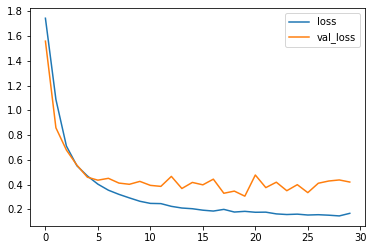

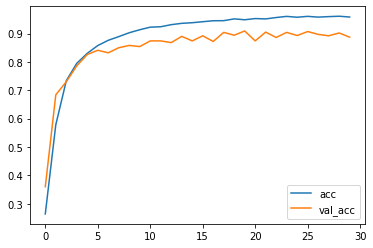

In [103]:
# plot some data
plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r2.history['accuracy'], label='acc')
plt.plot(r2.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()


In [105]:
### print story line weights again ###
debug_model2 = Model([input_story_,input_question_],[story_weights1,story_weights2])

In [110]:
# choose a random story
story_idx = np.random.choice(len(test_stories))

i=inputs_test[story_idx:story_idx+1]
q=queries_test[story_idx:story_idx+1]
w1,w2=debug_model2.predict([i,q])
w1 = w1.flatten()
w2 = w2.flatten()

In [111]:
story, question, ans = test_stories[story_idx]
print("story:\n")
# for j, line in enumerate(story):
#     print("{:1.5f}".format(w1[j]), "\t", "{:1.5f}".format(w2[j]), "\t", " ".join(line))

print("question:", " ".join(question))
print("answer:", ans)
print("prediction:", vocab[ np.argmax(model2.predict([i, q])[0]) ])

story:

question: Where is the football ?
answer: hallway
prediction: hallway
